## Differentiable Rendering

### Import and Functions

In [2]:
import os
import numpy
import open3d
import pathlib
import skimage

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

import torch
import torch.nn

from pytorch3d.io import load_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes, Pointclouds

from pytorch3d.renderer import (
    BlendParams,
    FoVPerspectiveCameras,
    HardPhongShader,
    look_at_rotation,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesVertex,
)


def visualize_point_cloud(point_cloud):
    pcd = open3d.io.read_point_cloud(point_cloud)
    open3d.visualization.draw_geometries([pcd], mesh_show_wireframe=True)


def visualize_point_cloud2(verts, device, renderer):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")


def visualize_point_cloud2_save(verts, device, renderer, index):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")
    plt.savefig(f"./out/image{index}.png")


def visualize_mesh(mesh):
    print(f"Visualizing the mesh {mesh} using open3D")
    mesh = open3d.io.read_triangle_mesh(mesh, enable_post_processing=True)
    open3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)


def delete_from_disk(path: pathlib.Path):
    if path.is_file() or path.is_symlink():
        path.unlink()
        return
    for p in path.iterdir():
        delete_from_disk(p)
    path.rmdir()


out_path = os.path.abspath("./out")
if os.path.isdir(out_path):
    delete_from_disk(pathlib.Path(out_path))
os.mkdir(out_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Pose Detection

In [3]:
visualize_mesh("teapot.obj")

Visualizing the mesh teapot.obj using open3D


c:\tools\miniconda3\envs\torch3d\Lib\site-packages\pytorch3d\io\obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


Saving animation
Finished


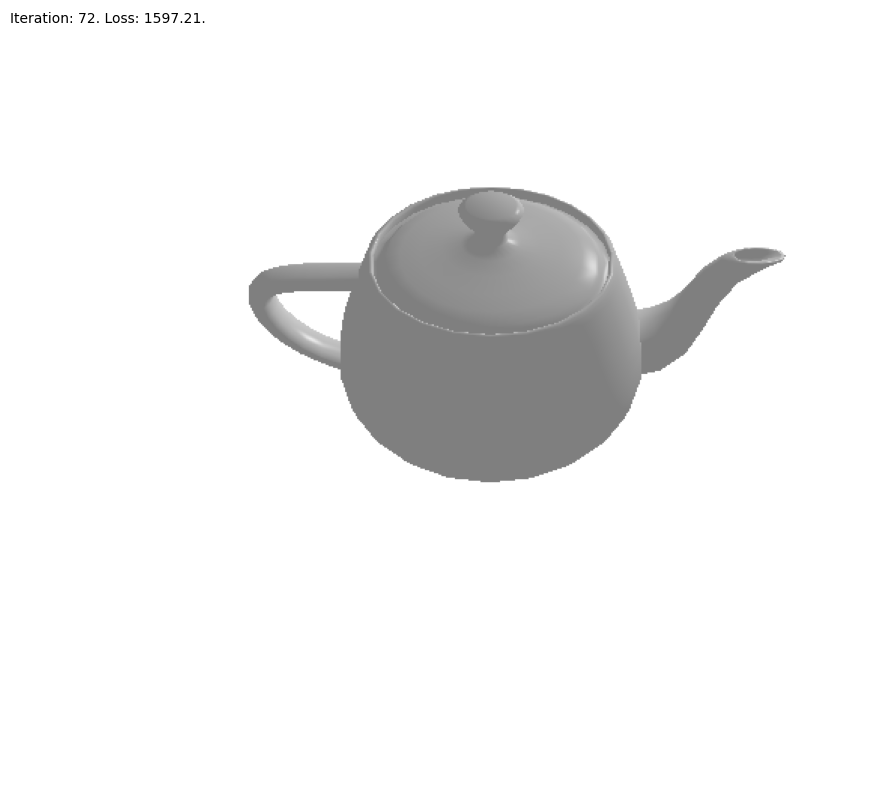

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

output_dir = os.path.join(out_path, "teapot")
if os.path.isdir(output_dir):
    delete_from_disk(pathlib.Path(output_dir))
os.mkdir(output_dir)

verts, faces_idx, _ = load_obj("teapot.obj")
faces = faces_idx.verts_idx

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

teapot_mesh = Meshes(verts=[verts.to(device)], faces=[faces.to(device)], textures=textures)

cameras = FoVPerspectiveCameras(device=device)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=numpy.log(1.0 / 1e-4 - 1.0) * blend_params.sigma,
    faces_per_pixel=100,
)

silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params),
)

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights),
)

distance = 3
elevation = 50.0
azimuth = 0.0

R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.savefig(os.path.join(output_dir, "target_silhouette.png"))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, "target_rgb.png"))
plt.close()


class Model(torch.nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(numpy.float32))
        self.register_buffer("image_ref", image_ref)

        self.camera_position = torch.nn.Parameter(torch.from_numpy(numpy.array([3.0, 6.9, +2.5], dtype=numpy.float32)).to(meshes.device))

    def forward(self):
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image


model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

_, image_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, "starting_silhouette.png"))
plt.close()

frames = []  # for storing the generated images
fig = plt.figure(figsize=(10, 10))
for i in range(0, 200):
    # if i % 100 == 0:
    #     print("i = ", i)

    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    if loss.item() < 1500:
        break

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
    with torch.no_grad():
        title = plt.text(1, 1, f"Iteration: {i}. Loss: {loss.data:.2f}.", horizontalalignment="center", verticalalignment="top")
        frames.append([plt.imshow(image[0, ..., :3].cpu().numpy(), animated=True), title])
    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = skimage.img_as_ubyte(image)

    # frames.append([plt.imshow(image[..., :3], animated=True)])
    # plt.imshow(image[..., :3])
    # plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    # plt.axis("off")
    # plt.savefig(os.path.join(output_dir, "fitting_" + str(i) + ".png"))
    # plt.close()

plt.axis("off")
# plt.show()
print("Saving animation")
anim = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
anim.save(os.path.join(out_path, "teapot_animation.mp4"))

print("Finished")

### Pose Detection with Texture

In [5]:
visualize_mesh("spot/spot.obj")

Visualizing the mesh spot/spot.obj using open3D


Saving animation
Finished


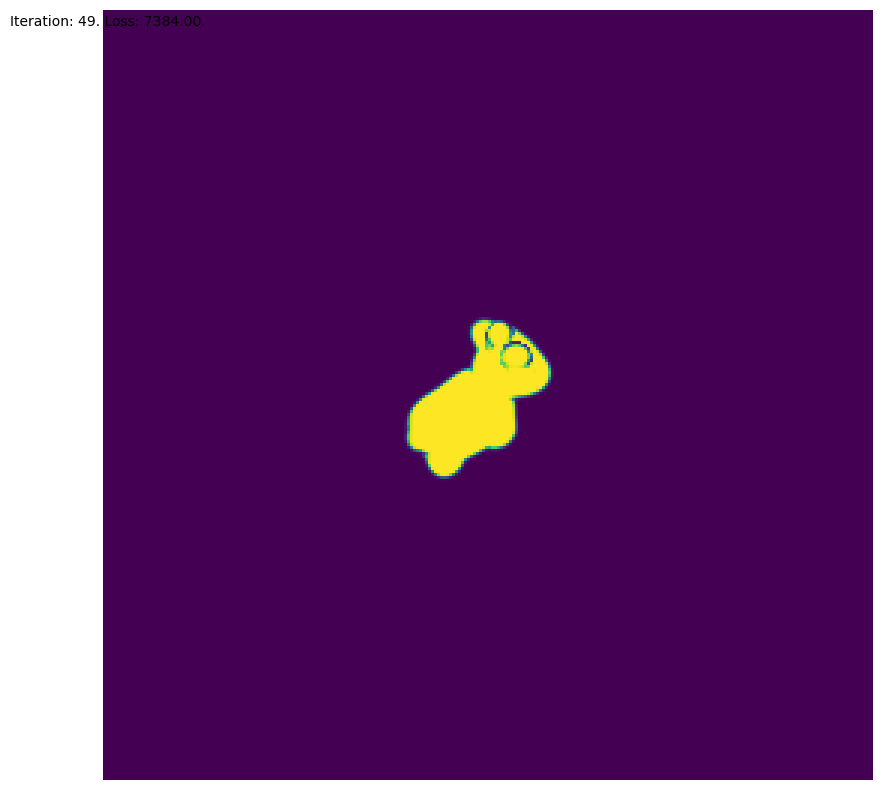

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

output_dir = os.path.join(out_path, "spot")
if os.path.isdir(output_dir):
    delete_from_disk(pathlib.Path(output_dir))
os.mkdir(output_dir)

obj_filename = "./spot/spot.obj"
spot_mesh = load_objs_as_meshes([obj_filename], device=device)

cameras = FoVPerspectiveCameras(device=device)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=numpy.log(1.0 / 1e-4 - 1.0) * blend_params.sigma,
    faces_per_pixel=100,
)
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params),
)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256,
    blur_radius=numpy.log(1.0 / 1e-4 - 1.0) * sigma,
    faces_per_pixel=50,
)
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings_soft),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
)

raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights),
)

distance = 3
elevation = 50.0
azimuth = 0.0
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

silhouette = renderer_silhouette(meshes_world=spot_mesh, R=R, T=T)
silhouette = silhouette.cpu().numpy()

image_ref = phong_renderer(meshes_world=spot_mesh, R=R, T=T)
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, "target_silhouette.png"))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, "target_rgb.png"))
plt.close()


class Model(torch.nn.Module):
    def __init__(self, meshes, renderer_silhouette, renderer_textured, image_ref, weight_silhouette, weight_texture):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer_silhouette = renderer_silhouette
        self.renderer_textured = renderer_textured
        self.weight_silhouette = weight_silhouette
        self.weight_texture = weight_texture

        image_ref_silhouette = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(numpy.float32))
        self.register_buffer("image_ref_silhouette", image_ref_silhouette)

        image_ref_textured = torch.from_numpy((image_ref[..., :3]).astype(numpy.float32))
        self.register_buffer("image_ref_textured", image_ref_textured)

        self.camera_position = torch.nn.Parameter(torch.from_numpy(numpy.array([3.0, 6.9, 2.5], dtype=numpy.float32)).to(meshes.device))

    def forward(self):
        R = look_at_rotation(self.camera_position[None, :], device=self.device)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image_silhouette = self.renderer_silhouette(meshes_world=self.meshes.clone(), R=R, T=T)
        image_textured = self.renderer_textured(meshes_world=self.meshes.clone(), R=R, T=T)

        loss_silhouette = torch.sum((image_silhouette[..., 3] - self.image_ref_silhouette) ** 2)
        loss_texture = torch.sum((image_textured[..., :3] - self.image_ref_textured) ** 2)

        loss = self.weight_silhouette * loss_silhouette + self.weight_texture * loss_texture
        return loss, image_silhouette, image_textured

model = Model(
    meshes=spot_mesh,
    renderer_silhouette=renderer_silhouette,
    renderer_textured=renderer_textured,
    image_ref=image_ref,
    weight_silhouette=1.0,
    weight_texture=0.1,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

_, image_silhouette_init, image_rgb_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_silhouette_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, "starting_silhouette.png"))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb_init.cpu().detach().numpy().squeeze())
plt.grid(False)
plt.title("Starting RGB Image")
plt.savefig(os.path.join(output_dir, "starting_rgb.png"))
plt.close()

# Frames for storing the generated images
frames_soft_silhouette = []
frames_soft_texture = []
frames_hard_silhouette = []
frames_hard_texture = []

fig_soft_silhouette = plt.figure(figsize=(10, 10))
# fig_soft_texture = plt.figure(figsize=(10, 10))
# fig_hard_silhouette = plt.figure(figsize=(10, 10))
# fig_hard_texture = plt.figure(figsize=(10, 10))

for i in range(0, 50):
    # if i % 100 == 0:
    #     print("i = ", i)

    optimizer.zero_grad()
    loss, image_silhouette, image_textured = model()
    loss.backward()
    optimizer.step()

    if loss.item() < 800:
        break

    # with torch.no_grad():
    title_soft_silhouette = plt.text(1, 1, f"Iteration: {i}. Loss: {loss.data:.2f}.", horizontalalignment="center", verticalalignment="top")
    frames_soft_silhouette.append([plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy(), animated=True), title_soft_silhouette])
    # plt.figure()
    # plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy())
    # plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    # plt.axis("off")
    # plt.savefig(os.path.join(output_dir, "soft_silhouette_" + str(i) + ".png"))
    # plt.close()

    # with torch.no_grad():
    #     title_soft_texture = plt.text(1, 1, f"Iteration: {i}. Loss: {loss.data:.2f}.", horizontalalignment='center', verticalalignment='top')
    #     frames_soft_texture.append([plt.imshow(image_textured[0, ..., :3].cpu().numpy(), animated=True), title_soft_texture])
    # plt.figure()
    # plt.imshow(image_textured.detach().squeeze().cpu().numpy())
    # plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    # plt.axis("off")
    # plt.savefig(os.path.join(output_dir, "soft_texture_" + str(i) + ".png"))
    # plt.close()

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)

    # with torch.no_grad():
    # title_hard_silhouette = plt.text(1, 1, f"Iteration: {i}. Loss: {loss.data:.2f}.", horizontalalignment="center", verticalalignment="top")
    # frames_hard_silhouette.append([plt.imshow(image[..., 3].detach().squeeze().cpu().numpy(), animated=True), title_hard_silhouette])
    # plt.figure()
    # plt.imshow(image[..., 3].detach().squeeze().cpu().numpy())
    # plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    # plt.axis("off")
    # plt.savefig(os.path.join(output_dir, "hard_silhouette_" + str(i) + ".png"))
    # plt.close()

    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = skimage.img_as_ubyte(image)

    # with torch.no_grad():
    #     title_hard_texture = plt.text(1, 1, f"Iteration: {i}. Loss: {loss.data:.2f}.", horizontalalignment='center', verticalalignment='top')
    #     frames_hard_texture.append([plt.imshow(image[0, ..., :3], animated=True), title_hard_texture])

    # plt.figure()
    # plt.imshow(image[..., :3])
    # plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    # plt.axis("off")
    # plt.savefig(os.path.join(output_dir, "hard_texture_" + str(i) + ".png"))
    # plt.close()

plt.axis("off")
# plt.show()
print("Saving animation")
anim = animation.ArtistAnimation(fig_soft_silhouette, frames_soft_silhouette, interval=50, blit=True, repeat_delay=1000)
anim.save(os.path.join(out_path, "spot_animation_soft_silhouette.mp4"))

# anim = animation.ArtistAnimation(fig_soft_texture, frames_soft_texture, interval=50, blit=True, repeat_delay=1000)
# anim.save(os.path.join(out_path, "spot_animation_soft_texture.mp4"))

# anim = animation.ArtistAnimation(fig_hard_silhouette, frames_hard_silhouette, interval=50, blit=True, repeat_delay=1000)
# anim.save(os.path.join(out_path, "spot_animation_hard_silhouette.mp4"))

# anim = animation.ArtistAnimation(fig_hard_texture, frames_hard_texture, interval=50, blit=True, repeat_delay=1000)
# anim.save(os.path.join(out_path, "spot_animation_hard_texture.mp4"))

print("Finished")